# IOB compression of an S-curve
This notebook demonstrates autoencoding compression of sklearn's S-curve dataset. Each sample in the dataset is a 3-dimensional vector representing a position in 3D space. The ensemble of points is shaped like an S, and thereby not seperable by linear means. In this notebook, we adaptively compress this distribution using IOBs and a dense neural network and show that we can estimate the intrinsic dimensionality of the dataset.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
from sklearn.datasets import make_s_curve
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from iobs.layers import IOBLayer
from iobs.models import BaseAE

/data80/mattho/anaconda3/envs/aeDROP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)

Device: cuda


## Generate dataset

In [3]:
# generate data
data, label = make_s_curve(
    n_samples=10000,
    noise=0.1
)

# center everything
data -= data.mean(axis=0)

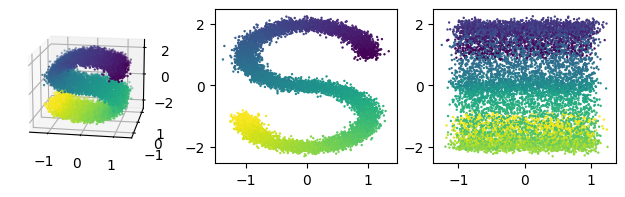

In [4]:
# plot dataset
f = plt.figure(figsize=(8,2))
gs = mpl.gridspec.GridSpec(1,3)

ax = f.add_subplot(gs[0,0], projection='3d')
ax.scatter(
    xs=data[:,0], 
    ys=data[:,1], 
    zs=data[:,2],
    rasterized=True, 
    c=label, s=0.5)
ax.view_init(elev=15., azim=-80)

ax = f.add_subplot(gs[0,1])
ax.scatter(
    x=data[:,0], 
    y=data[:,2],
    rasterized=True,
    c=label, s=0.5)

ax = f.add_subplot(gs[0,2])
ax.scatter(
    x=data[:,1], 
    y=data[:,2],
    rasterized=True,
    c=label, s=0.5)

In [5]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [6]:
# create dataset and dataloaders
class SimulatedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx]

train_dataset = SimulatedDataset(data[in_train])
val_dataset = SimulatedDataset(data[in_val])
test_dataset = SimulatedDataset(data[in_test])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Define encoder-decoder architecture

In [7]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a fully-connected encoder
encoder = nn.Sequential(
    *(build_dense_sequence([3, 64, 64, 4])),
).to(device)

# define a fully-connected decoder
decoder = nn.Sequential(
    *(build_dense_sequence([4, 64, 64, 3])),
).to(device)

# define a IOB with a max width of 4 features
bottleneck = IOBLayer(4, device=device)

In [8]:
# build a simple autoencoder model
model = BaseAE(
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [9]:
# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

## Train

In [10]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 1e-4
print_every = 10

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [11]:
trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()*len(batch_features)
    trloss = trloss / len(train_dataset)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()*len(batch_features)
        valoss = valoss / len(val_dataset)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    if epoch % print_every == 0:
        print(f"epoch : {epoch + 1}/{max_epochs}, "
              f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

epoch : 1/3000, loss = 0.893747, val loss = 0.803698
epoch : 11/3000, loss = 0.260391, val loss = 0.263852
epoch : 21/3000, loss = 0.241863, val loss = 0.244551
epoch : 31/3000, loss = 0.228549, val loss = 0.230688
epoch : 41/3000, loss = 0.220981, val loss = 0.223177
epoch : 51/3000, loss = 0.216853, val loss = 0.219165
epoch : 61/3000, loss = 0.214582, val loss = 0.216770
epoch : 71/3000, loss = 0.213325, val loss = 0.215562
epoch : 81/3000, loss = 0.212650, val loss = 0.214809
epoch : 91/3000, loss = 0.212201, val loss = 0.214563
epoch : 101/3000, loss = 0.211970, val loss = 0.214414
epoch : 111/3000, loss = 0.211743, val loss = 0.213994
epoch : 121/3000, loss = 0.211533, val loss = 0.214015
epoch : 131/3000, loss = 0.211447, val loss = 0.213803
epoch : 141/3000, loss = 0.211249, val loss = 0.213524
epoch : 151/3000, loss = 0.211139, val loss = 0.213299
epoch : 161/3000, loss = 0.211042, val loss = 0.213236
epoch : 171/3000, loss = 0.210841, val loss = 0.213086
epoch : 181/3000, los

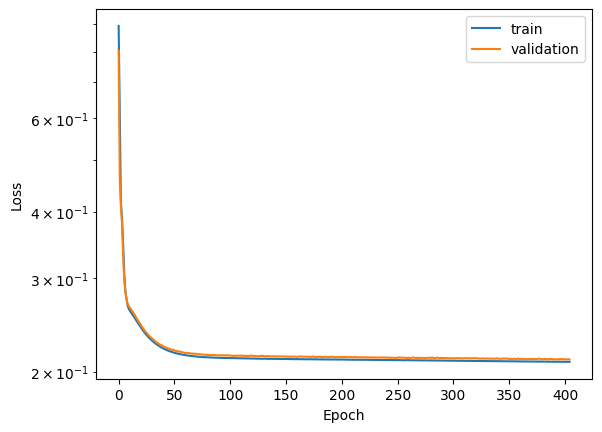

In [12]:
# plot loss vs. time
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
# ax.plot(range(lenrec), np.array(trloss_rec)-np.array(valoss_rec), label='train')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()

## Test

In [13]:
# embed and reconstruct all test images, for all possible bottleneck widths
test_data = test_dataset.data
test_label = label[in_test]
recon_data = np.zeros_like(test_data)
recon_data = np.repeat(recon_data[:,None,...], repeats=model.latent_dim+1, axis=1)
with torch.no_grad():
    i = 0
    for j, batch_features in enumerate(test_loader):
        batch_features = batch_features.float().to(device)
        recon_data[i:i+len(batch_features)] = \
            model.forward_all(batch_features).detach().cpu()
        i += len(batch_features)

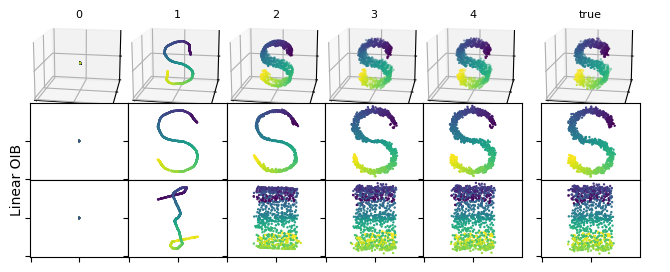

In [14]:
# show reconstruction examples, as a function of bottleneck width
lmin = test_data.min()*1.1
lmax = test_data.max()*1.1

def plot3d(data, label, gsax):
    ax = fig.add_subplot(gsax, projection='3d')
    ax.scatter(
        xs=data[:,0], 
        ys=data[:,1], 
        zs=data[:,2], 
        rasterized=True,  
        c=label, s=0.5)
    ax.set_xlim(lmin, lmax)
    ax.set_ylim(lmin, lmax)
    ax.set_zlim(lmin, lmax)
    ax.view_init(elev=15., azim=-80)
    ax.set_box_aspect(None, zoom=1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    return ax

def plot2d(data, label, gsax):
    ax = fig.add_subplot(gsax)
    ax.scatter(
        x=data[:, 0], 
        y=data[:, 1],
        rasterized=True,    
        c=label, s=0.5)
    ax.set_xlim(lmin, lmax)
    ax.set_ylim(lmin, lmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return gsax

fig = plt.figure(figsize=(8,3))
gs = mpl.gridspec.GridSpec(3,8, hspace=0, wspace=0,
                           width_ratios=[1]+[10]*5+[2,10])

ax = fig.add_subplot(gs[1:,0])
ax.axis('off')
ax.text(-1,0.5,'Linear OIB', va='center', ha='left', rotation=90)

# plot Linear
for i in range(1, 6):
    ax = plot3d(recon_data[:,i-1,:], test_label, gs[0,i])
    ax.set_title(i-1, fontsize=8)
    
    ax = plot2d(recon_data[:,i-1,[0,2]], test_label, gs[1,i])
    ax = plot2d(recon_data[:,i-1,[1,2]], test_label, gs[2,i])

# plot true
ax = plot3d(test_data, test_label, gs[0,-1])
ax.set_title('true', fontsize=8)

ax = plot2d(test_data[:,[0,2]], test_label, gs[1,-1])
ax = plot2d(test_data[:,[1,2]], test_label, gs[2,-1])

Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

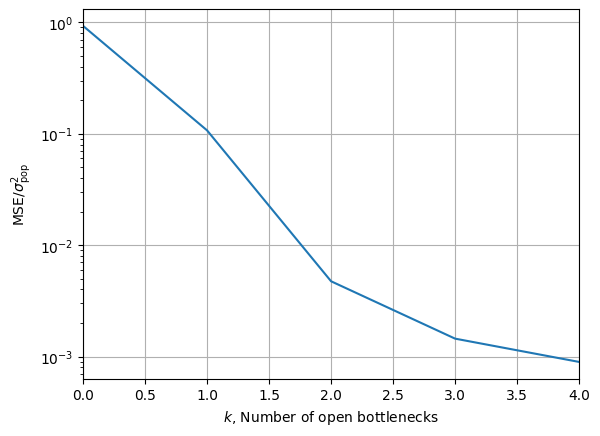

In [15]:
# calculate and plot the % variance explained, as a function of bottlneeck width
testvar = np.sum(np.var(test_data, axis=0).shape)
test_percerr = np.sum(np.mean((recon_data-test_data[:,None])**2, axis=0), axis=(1))/testvar

f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

## Calculate intrinsic dimensionality

In [16]:
# calculate intrinisic dimensionality

p = 0.05  # p-value at which to reject the null hypothesis
diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(diff_loglik<chi2.isf(p,1))[0,0]
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 2
